# Spike Detection Algorithm Analysis

Can we automatically detect when there's lots of positive or negative sentiment discussion in a subreddit on a particular day?

The goal of the this notebook is to identify "spikes" in the daily average sentiment score
- We care about both positive or negative spikes
- We want the "spike" to be significant relative to historical values

This notebook
- Walks through importing data from the HuggingFace dataset hub
- Compares a few different spike definitions based on rolling statistics
- Selects the best spike definition based on sanity checking against historical data

### Imports and Definitions

In [10]:
import os
import glob
import datetime
from pathlib import Path
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import pyarrow

from huggingface_hub import HfApi

In [5]:
def load_reddit_data(folder='data_scored'):
    df = []
    repo_id = "hblim/top_reddit_posts_daily"
    api = HfApi()
    all_files = api.list_repo_files(repo_id, repo_type="dataset")
    parquet_files = sorted([f for f in all_files if f.startswith(folder) and f.endswith(".parquet")])

    for shard in parquet_files:
        local_path = api.hf_hub_download(repo_id=repo_id, filename=shard, repo_type="dataset")
        file_date = os.path.splitext(os.path.basename(local_path))[0]
        df.append(pd.read_parquet(local_path).assign(filedate=file_date))

    df = pd.concat(df, ignore_index=True)
    print(f"Total records across {df.filedate.nunique()} days: {len(df)}")
    return df

In [88]:
def summary_from_df(df: pd.DataFrame, gamma_post: float = 0.3) -> pd.DataFrame:
    """
    Return a DataFrame with daily & subreddit aggregates.

    Expects columns:
        retrieved_at  - UTC timestamp or ISO-date string
        subreddit     - subreddit name
        sentiment     - numeric score (e.g. −1 … 1)
        score         - numeric weight / post score

    Output columns:
        date               (datetime.date)
        subreddit          (string)
        community_weighted_sentiment
        count
    """
    # Normalize retrieved_at to datetime and extract calendar day
    df = df.copy()
    df["date"] = pd.to_datetime(df["retrieved_at"]).dt.date
    
    # Group by date and subreddit
    grouped = df.groupby(["date", "subreddit"])
    
    # Aggregate metrics
    result = grouped.agg(
        # First calculate raw mean_sentiment
        raw_mean_sentiment=("sentiment", "mean"),
        count=("sentiment", "count"),
    ).reset_index()
    
    # Apply transformation to raw_mean_sentiment to get values in range [-1, 1] instead of [0, 1]
    result["mean_sentiment"] = 2 * result["raw_mean_sentiment"] - 1
    
    # Remove the raw mean column
    result = result.drop(columns="raw_mean_sentiment")
    
    # Calculate engagement-adjusted sentiment (EAS) for each group
    # 1. Ensure 'score' is numeric
    df["score_num"] = pd.to_numeric(df["score"], errors="coerce").fillna(0)
    # 2. Compute base weights (1 + log1p(score))
    weights_base = 1 + np.log1p(df["score_num"].clip(lower=0))
    # 3. Apply post weight multiplier
    weights = weights_base * np.where(df.get("type", None) == "post", gamma_post, 1.0)
    df["weight"] = weights
    # 4. Compute EAS per group: weighted average of sentiment
    community_weighted_sentiments = []
    for (date, subreddit), group in grouped:
        w = group["weight"]
        s = group["sentiment"]
        eas = (w * s).sum() / w.sum() if w.sum() > 0 else 0
        community_weighted_sentiments.append(eas)
    result["community_weighted_sentiment"] = community_weighted_sentiments
    
    # Normalize community_weighted_sentiment to range [-1,1]
    result["community_weighted_sentiment"] = 2 * result["community_weighted_sentiment"] - 1
    
    # Ensure consistent column order
    result = result[["date", "subreddit", "community_weighted_sentiment"]]
    
    return result

In [6]:
df = load_reddit_data()

2025-05-01.parquet:   0%|          | 0.00/271k [00:00<?, ?B/s]

2025-05-02.parquet:   0%|          | 0.00/202k [00:00<?, ?B/s]

2025-05-03.parquet:   0%|          | 0.00/231k [00:00<?, ?B/s]

2025-05-04.parquet:   0%|          | 0.00/195k [00:00<?, ?B/s]

2025-05-05.parquet:   0%|          | 0.00/225k [00:00<?, ?B/s]

2025-05-06.parquet:   0%|          | 0.00/225k [00:00<?, ?B/s]

2025-05-07.parquet:   0%|          | 0.00/188k [00:00<?, ?B/s]

2025-05-08.parquet:   0%|          | 0.00/228k [00:00<?, ?B/s]

2025-05-09.parquet:   0%|          | 0.00/221k [00:00<?, ?B/s]

2025-05-10.parquet:   0%|          | 0.00/190k [00:00<?, ?B/s]

2025-05-11.parquet:   0%|          | 0.00/193k [00:00<?, ?B/s]

2025-05-12.parquet:   0%|          | 0.00/230k [00:00<?, ?B/s]

2025-05-13.parquet:   0%|          | 0.00/221k [00:00<?, ?B/s]

2025-05-14.parquet:   0%|          | 0.00/252k [00:00<?, ?B/s]

2025-05-15.parquet:   0%|          | 0.00/238k [00:00<?, ?B/s]

2025-05-16.parquet:   0%|          | 0.00/215k [00:00<?, ?B/s]

2025-05-17.parquet:   0%|          | 0.00/211k [00:00<?, ?B/s]

2025-05-18.parquet:   0%|          | 0.00/181k [00:00<?, ?B/s]

2025-05-19.parquet:   0%|          | 0.00/203k [00:00<?, ?B/s]

2025-05-20.parquet:   0%|          | 0.00/200k [00:00<?, ?B/s]

2025-05-21.parquet:   0%|          | 0.00/305k [00:00<?, ?B/s]

2025-05-22.parquet:   0%|          | 0.00/268k [00:00<?, ?B/s]

2025-05-23.parquet:   0%|          | 0.00/245k [00:00<?, ?B/s]

2025-05-24.parquet:   0%|          | 0.00/255k [00:00<?, ?B/s]

2025-05-25.parquet:   0%|          | 0.00/232k [00:00<?, ?B/s]

2025-05-26.parquet:   0%|          | 0.00/229k [00:00<?, ?B/s]

2025-05-27.parquet:   0%|          | 0.00/232k [00:00<?, ?B/s]

2025-05-28.parquet:   0%|          | 0.00/270k [00:00<?, ?B/s]

2025-05-29.parquet:   0%|          | 0.00/262k [00:00<?, ?B/s]

2025-05-30.parquet:   0%|          | 0.00/240k [00:00<?, ?B/s]

2025-05-31.parquet:   0%|          | 0.00/231k [00:00<?, ?B/s]

2025-06-01.parquet:   0%|          | 0.00/167k [00:00<?, ?B/s]

2025-06-02.parquet:   0%|          | 0.00/250k [00:00<?, ?B/s]

2025-06-03.parquet:   0%|          | 0.00/206k [00:00<?, ?B/s]

2025-06-04.parquet:   0%|          | 0.00/269k [00:00<?, ?B/s]

2025-05-01__artificial.parquet:   0%|          | 0.00/36.2k [00:00<?, ?B/s]

2025-05-01__localllama.parquet:   0%|          | 0.00/151k [00:00<?, ?B/s]

2025-05-01__openai.parquet:   0%|          | 0.00/59.1k [00:00<?, ?B/s]

2025-05-01__singularity.parquet:   0%|          | 0.00/51.6k [00:00<?, ?B/s]

2025-05-02__artificial.parquet:   0%|          | 0.00/25.5k [00:00<?, ?B/s]

2025-05-02__localllama.parquet:   0%|          | 0.00/89.5k [00:00<?, ?B/s]

2025-05-02__openai.parquet:   0%|          | 0.00/66.8k [00:00<?, ?B/s]

2025-05-02__singularity.parquet:   0%|          | 0.00/44.8k [00:00<?, ?B/s]

2025-05-03__artificial.parquet:   0%|          | 0.00/25.3k [00:00<?, ?B/s]

2025-05-03__localllama.parquet:   0%|          | 0.00/113k [00:00<?, ?B/s]

2025-05-03__openai.parquet:   0%|          | 0.00/60.2k [00:00<?, ?B/s]

2025-05-03__singularity.parquet:   0%|          | 0.00/57.9k [00:00<?, ?B/s]

2025-05-04__artificial.parquet:   0%|          | 0.00/23.6k [00:00<?, ?B/s]

2025-05-04__localllama.parquet:   0%|          | 0.00/83.6k [00:00<?, ?B/s]

2025-05-04__openai.parquet:   0%|          | 0.00/68.2k [00:00<?, ?B/s]

2025-05-04__singularity.parquet:   0%|          | 0.00/42.0k [00:00<?, ?B/s]

2025-05-05__artificial.parquet:   0%|          | 0.00/12.2k [00:00<?, ?B/s]

2025-05-05__localllama.parquet:   0%|          | 0.00/108k [00:00<?, ?B/s]

2025-05-05__openai.parquet:   0%|          | 0.00/65.9k [00:00<?, ?B/s]

2025-05-05__singularity.parquet:   0%|          | 0.00/62.5k [00:00<?, ?B/s]

2025-05-06__artificial.parquet:   0%|          | 0.00/32.2k [00:00<?, ?B/s]

2025-05-06__localllama.parquet:   0%|          | 0.00/107k [00:00<?, ?B/s]

2025-05-06__openai.parquet:   0%|          | 0.00/68.4k [00:00<?, ?B/s]

2025-05-06__singularity.parquet:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-05-07__artificial.parquet:   0%|          | 0.00/32.8k [00:00<?, ?B/s]

2025-05-07__localllama.parquet:   0%|          | 0.00/89.0k [00:00<?, ?B/s]

2025-05-07__openai.parquet:   0%|          | 0.00/46.6k [00:00<?, ?B/s]

2025-05-07__singularity.parquet:   0%|          | 0.00/45.4k [00:00<?, ?B/s]

2025-05-08__artificial.parquet:   0%|          | 0.00/21.3k [00:00<?, ?B/s]

2025-05-08__localllama.parquet:   0%|          | 0.00/96.9k [00:00<?, ?B/s]

2025-05-08__openai.parquet:   0%|          | 0.00/72.3k [00:00<?, ?B/s]

2025-05-08__singularity.parquet:   0%|          | 0.00/61.1k [00:00<?, ?B/s]

2025-05-09__artificial.parquet:   0%|          | 0.00/18.5k [00:00<?, ?B/s]

2025-05-09__localllama.parquet:   0%|          | 0.00/95.1k [00:00<?, ?B/s]

2025-05-09__openai.parquet:   0%|          | 0.00/66.6k [00:00<?, ?B/s]

2025-05-09__singularity.parquet:   0%|          | 0.00/64.4k [00:00<?, ?B/s]

2025-05-10__artificial.parquet:   0%|          | 0.00/27.6k [00:00<?, ?B/s]

2025-05-10__localllama.parquet:   0%|          | 0.00/74.8k [00:00<?, ?B/s]

2025-05-10__openai.parquet:   0%|          | 0.00/62.1k [00:00<?, ?B/s]

2025-05-10__singularity.parquet:   0%|          | 0.00/49.6k [00:00<?, ?B/s]

2025-05-11__artificial.parquet:   0%|          | 0.00/24.4k [00:00<?, ?B/s]

2025-05-11__localllama.parquet:   0%|          | 0.00/87.3k [00:00<?, ?B/s]

2025-05-11__openai.parquet:   0%|          | 0.00/61.2k [00:00<?, ?B/s]

2025-05-11__singularity.parquet:   0%|          | 0.00/43.2k [00:00<?, ?B/s]

2025-05-12__artificial.parquet:   0%|          | 0.00/34.5k [00:00<?, ?B/s]

2025-05-12__localllama.parquet:   0%|          | 0.00/91.9k [00:00<?, ?B/s]

2025-05-12__openai.parquet:   0%|          | 0.00/63.9k [00:00<?, ?B/s]

2025-05-12__singularity.parquet:   0%|          | 0.00/67.2k [00:00<?, ?B/s]

2025-05-13__artificial.parquet:   0%|          | 0.00/31.6k [00:00<?, ?B/s]

2025-05-13__localllama.parquet:   0%|          | 0.00/110k [00:00<?, ?B/s]

2025-05-13__openai.parquet:   0%|          | 0.00/77.2k [00:00<?, ?B/s]

2025-05-13__singularity.parquet:   0%|          | 0.00/34.1k [00:00<?, ?B/s]

2025-05-14__artificial.parquet:   0%|          | 0.00/44.0k [00:00<?, ?B/s]

2025-05-14__localllama.parquet:   0%|          | 0.00/86.7k [00:00<?, ?B/s]

2025-05-14__openai.parquet:   0%|          | 0.00/77.2k [00:00<?, ?B/s]

2025-05-14__singularity.parquet:   0%|          | 0.00/67.7k [00:00<?, ?B/s]

2025-05-15__artificial.parquet:   0%|          | 0.00/27.5k [00:00<?, ?B/s]

2025-05-15__localllama.parquet:   0%|          | 0.00/91.4k [00:00<?, ?B/s]

2025-05-15__openai.parquet:   0%|          | 0.00/62.5k [00:00<?, ?B/s]

2025-05-15__singularity.parquet:   0%|          | 0.00/87.4k [00:00<?, ?B/s]

2025-05-16__artificial.parquet:   0%|          | 0.00/28.3k [00:00<?, ?B/s]

2025-05-16__localllama.parquet:   0%|          | 0.00/88.7k [00:00<?, ?B/s]

2025-05-16__openai.parquet:   0%|          | 0.00/61.3k [00:00<?, ?B/s]

2025-05-16__singularity.parquet:   0%|          | 0.00/61.4k [00:00<?, ?B/s]

2025-05-17__artificial.parquet:   0%|          | 0.00/31.0k [00:00<?, ?B/s]

2025-05-17__localllama.parquet:   0%|          | 0.00/83.0k [00:00<?, ?B/s]

2025-05-17__openai.parquet:   0%|          | 0.00/75.9k [00:00<?, ?B/s]

2025-05-17__singularity.parquet:   0%|          | 0.00/55.8k [00:00<?, ?B/s]

2025-05-18__artificial.parquet:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

2025-05-18__localllama.parquet:   0%|          | 0.00/89.1k [00:00<?, ?B/s]

2025-05-18__openai.parquet:   0%|          | 0.00/59.9k [00:00<?, ?B/s]

2025-05-18__singularity.parquet:   0%|          | 0.00/37.0k [00:00<?, ?B/s]

2025-05-19__artificial.parquet:   0%|          | 0.00/34.9k [00:00<?, ?B/s]

2025-05-19__localllama.parquet:   0%|          | 0.00/83.4k [00:00<?, ?B/s]

2025-05-19__openai.parquet:   0%|          | 0.00/39.2k [00:00<?, ?B/s]

2025-05-19__singularity.parquet:   0%|          | 0.00/74.1k [00:00<?, ?B/s]

2025-05-20__artificial.parquet:   0%|          | 0.00/29.8k [00:00<?, ?B/s]

2025-05-20__localllama.parquet:   0%|          | 0.00/76.2k [00:00<?, ?B/s]

2025-05-20__openai.parquet:   0%|          | 0.00/44.1k [00:00<?, ?B/s]

2025-05-20__singularity.parquet:   0%|          | 0.00/74.3k [00:00<?, ?B/s]

2025-05-21__artificial.parquet:   0%|          | 0.00/30.5k [00:00<?, ?B/s]

2025-05-21__localllama.parquet:   0%|          | 0.00/103k [00:00<?, ?B/s]

2025-05-21__openai.parquet:   0%|          | 0.00/63.5k [00:00<?, ?B/s]

2025-05-21__singularity.parquet:   0%|          | 0.00/134k [00:00<?, ?B/s]

2025-05-22__artificial.parquet:   0%|          | 0.00/29.3k [00:00<?, ?B/s]

2025-05-22__localllama.parquet:   0%|          | 0.00/107k [00:00<?, ?B/s]

2025-05-22__openai.parquet:   0%|          | 0.00/72.0k [00:00<?, ?B/s]

2025-05-22__singularity.parquet:   0%|          | 0.00/84.4k [00:00<?, ?B/s]

2025-05-23__artificial.parquet:   0%|          | 0.00/44.2k [00:00<?, ?B/s]

2025-05-23__localllama.parquet:   0%|          | 0.00/97.4k [00:00<?, ?B/s]

2025-05-23__openai.parquet:   0%|          | 0.00/53.4k [00:00<?, ?B/s]

2025-05-23__singularity.parquet:   0%|          | 0.00/80.9k [00:00<?, ?B/s]

2025-05-24__artificial.parquet:   0%|          | 0.00/36.4k [00:00<?, ?B/s]

2025-05-24__localllama.parquet:   0%|          | 0.00/88.0k [00:00<?, ?B/s]

2025-05-24__openai.parquet:   0%|          | 0.00/66.3k [00:00<?, ?B/s]

2025-05-24__singularity.parquet:   0%|          | 0.00/102k [00:00<?, ?B/s]

2025-05-25__artificial.parquet:   0%|          | 0.00/46.3k [00:00<?, ?B/s]

2025-05-25__localllama.parquet:   0%|          | 0.00/77.1k [00:00<?, ?B/s]

2025-05-25__openai.parquet:   0%|          | 0.00/63.2k [00:00<?, ?B/s]

2025-05-25__singularity.parquet:   0%|          | 0.00/71.1k [00:00<?, ?B/s]

2025-05-26__artificial.parquet:   0%|          | 0.00/29.4k [00:00<?, ?B/s]

2025-05-26__localllama.parquet:   0%|          | 0.00/103k [00:00<?, ?B/s]

2025-05-26__openai.parquet:   0%|          | 0.00/59.3k [00:00<?, ?B/s]

2025-05-26__singularity.parquet:   0%|          | 0.00/64.8k [00:00<?, ?B/s]

2025-05-27__artificial.parquet:   0%|          | 0.00/32.8k [00:00<?, ?B/s]

2025-05-27__localllama.parquet:   0%|          | 0.00/86.4k [00:00<?, ?B/s]

2025-05-27__openai.parquet:   0%|          | 0.00/50.3k [00:00<?, ?B/s]

2025-05-27__singularity.parquet:   0%|          | 0.00/85.7k [00:00<?, ?B/s]

2025-05-28__artificial.parquet:   0%|          | 0.00/27.6k [00:00<?, ?B/s]

2025-05-28__localllama.parquet:   0%|          | 0.00/93.1k [00:00<?, ?B/s]

2025-05-28__openai.parquet:   0%|          | 0.00/62.4k [00:00<?, ?B/s]

2025-05-28__singularity.parquet:   0%|          | 0.00/115k [00:00<?, ?B/s]

2025-05-29__artificial.parquet:   0%|          | 0.00/26.9k [00:00<?, ?B/s]

2025-05-29__localllama.parquet:   0%|          | 0.00/123k [00:00<?, ?B/s]

2025-05-29__openai.parquet:   0%|          | 0.00/42.5k [00:00<?, ?B/s]

2025-05-29__singularity.parquet:   0%|          | 0.00/100k [00:00<?, ?B/s]

2025-05-30__artificial.parquet:   0%|          | 0.00/29.4k [00:00<?, ?B/s]

2025-05-30__localllama.parquet:   0%|          | 0.00/94.9k [00:00<?, ?B/s]

2025-05-30__openai.parquet:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

2025-05-30__singularity.parquet:   0%|          | 0.00/88.7k [00:00<?, ?B/s]

2025-05-31__artificial.parquet:   0%|          | 0.00/34.1k [00:00<?, ?B/s]

2025-05-31__localllama.parquet:   0%|          | 0.00/82.8k [00:00<?, ?B/s]

2025-05-31__openai.parquet:   0%|          | 0.00/58.9k [00:00<?, ?B/s]

2025-05-31__singularity.parquet:   0%|          | 0.00/82.2k [00:00<?, ?B/s]

2025-06-01__artificial.parquet:   0%|          | 0.00/12.9k [00:00<?, ?B/s]

2025-06-01__localllama.parquet:   0%|          | 0.00/71.4k [00:00<?, ?B/s]

2025-06-01__openai.parquet:   0%|          | 0.00/52.1k [00:00<?, ?B/s]

2025-06-01__singularity.parquet:   0%|          | 0.00/50.8k [00:00<?, ?B/s]

2025-06-02__artificial.parquet:   0%|          | 0.00/30.2k [00:00<?, ?B/s]

2025-06-02__localllama.parquet:   0%|          | 0.00/102k [00:00<?, ?B/s]

2025-06-02__openai.parquet:   0%|          | 0.00/59.5k [00:00<?, ?B/s]

2025-06-02__singularity.parquet:   0%|          | 0.00/81.2k [00:00<?, ?B/s]

2025-06-03__artificial.parquet:   0%|          | 0.00/37.6k [00:00<?, ?B/s]

2025-06-03__localllama.parquet:   0%|          | 0.00/76.1k [00:00<?, ?B/s]

2025-06-03__openai.parquet:   0%|          | 0.00/59.1k [00:00<?, ?B/s]

2025-06-03__singularity.parquet:   0%|          | 0.00/57.1k [00:00<?, ?B/s]

2025-06-04__artificial.parquet:   0%|          | 0.00/35.2k [00:00<?, ?B/s]

2025-06-04__localllama.parquet:   0%|          | 0.00/84.6k [00:00<?, ?B/s]

2025-06-04__openai.parquet:   0%|          | 0.00/88.2k [00:00<?, ?B/s]

2025-06-04__singularity.parquet:   0%|          | 0.00/84.3k [00:00<?, ?B/s]

2025-06-05__artificial.parquet:   0%|          | 0.00/26.9k [00:00<?, ?B/s]

2025-06-05__localllama.parquet:   0%|          | 0.00/83.3k [00:00<?, ?B/s]

2025-06-05__openai.parquet:   0%|          | 0.00/50.0k [00:00<?, ?B/s]

2025-06-05__singularity.parquet:   0%|          | 0.00/54.7k [00:00<?, ?B/s]

2025-06-06__artificial.parquet:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

2025-06-06__localllama.parquet:   0%|          | 0.00/69.2k [00:00<?, ?B/s]

2025-06-06__openai.parquet:   0%|          | 0.00/36.0k [00:00<?, ?B/s]

2025-06-06__singularity.parquet:   0%|          | 0.00/57.7k [00:00<?, ?B/s]

2025-06-07__artificial.parquet:   0%|          | 0.00/31.5k [00:00<?, ?B/s]

2025-06-07__localllama.parquet:   0%|          | 0.00/63.9k [00:00<?, ?B/s]

2025-06-07__openai.parquet:   0%|          | 0.00/58.0k [00:00<?, ?B/s]

2025-06-07__singularity.parquet:   0%|          | 0.00/64.4k [00:00<?, ?B/s]

2025-06-08__artificial.parquet:   0%|          | 0.00/31.4k [00:00<?, ?B/s]

2025-06-08__localllama.parquet:   0%|          | 0.00/84.0k [00:00<?, ?B/s]

2025-06-08__openai.parquet:   0%|          | 0.00/73.2k [00:00<?, ?B/s]

2025-06-08__singularity.parquet:   0%|          | 0.00/43.0k [00:00<?, ?B/s]

2025-06-09__artificial.parquet:   0%|          | 0.00/54.6k [00:00<?, ?B/s]

2025-06-09__localllama.parquet:   0%|          | 0.00/73.1k [00:00<?, ?B/s]

2025-06-09__openai.parquet:   0%|          | 0.00/67.2k [00:00<?, ?B/s]

2025-06-09__singularity.parquet:   0%|          | 0.00/72.1k [00:00<?, ?B/s]

2025-06-10__artificial.parquet:   0%|          | 0.00/33.6k [00:00<?, ?B/s]

2025-06-10__localllama.parquet:   0%|          | 0.00/83.8k [00:00<?, ?B/s]

2025-06-10__openai.parquet:   0%|          | 0.00/63.8k [00:00<?, ?B/s]

2025-06-10__singularity.parquet:   0%|          | 0.00/67.9k [00:00<?, ?B/s]

2025-06-11__artificial.parquet:   0%|          | 0.00/36.7k [00:00<?, ?B/s]

2025-06-11__localllama.parquet:   0%|          | 0.00/68.7k [00:00<?, ?B/s]

2025-06-11__openai.parquet:   0%|          | 0.00/57.4k [00:00<?, ?B/s]

2025-06-11__singularity.parquet:   0%|          | 0.00/47.9k [00:00<?, ?B/s]

2025-06-12__artificial.parquet:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

2025-06-12__localllama.parquet:   0%|          | 0.00/69.4k [00:00<?, ?B/s]

2025-06-12__openai.parquet:   0%|          | 0.00/63.3k [00:00<?, ?B/s]

2025-06-12__singularity.parquet:   0%|          | 0.00/57.7k [00:00<?, ?B/s]

2025-06-13__artificial.parquet:   0%|          | 0.00/44.1k [00:00<?, ?B/s]

2025-06-13__localllama.parquet:   0%|          | 0.00/76.7k [00:00<?, ?B/s]

2025-06-13__openai.parquet:   0%|          | 0.00/43.9k [00:00<?, ?B/s]

2025-06-13__singularity.parquet:   0%|          | 0.00/29.8k [00:00<?, ?B/s]

2025-06-14__artificial.parquet:   0%|          | 0.00/27.0k [00:00<?, ?B/s]

2025-06-14__localllama.parquet:   0%|          | 0.00/61.6k [00:00<?, ?B/s]

2025-06-14__openai.parquet:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

2025-06-14__singularity.parquet:   0%|          | 0.00/59.3k [00:00<?, ?B/s]

2025-06-15__artificial.parquet:   0%|          | 0.00/31.0k [00:00<?, ?B/s]

2025-06-15__localllama.parquet:   0%|          | 0.00/73.9k [00:00<?, ?B/s]

2025-06-15__openai.parquet:   0%|          | 0.00/37.5k [00:00<?, ?B/s]

2025-06-15__singularity.parquet:   0%|          | 0.00/39.5k [00:00<?, ?B/s]

2025-06-16__artificial.parquet:   0%|          | 0.00/30.6k [00:00<?, ?B/s]

2025-06-16__localllama.parquet:   0%|          | 0.00/78.7k [00:00<?, ?B/s]

2025-06-16__openai.parquet:   0%|          | 0.00/100k [00:00<?, ?B/s]

2025-06-16__singularity.parquet:   0%|          | 0.00/31.1k [00:00<?, ?B/s]

2025-06-17__artificial.parquet:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

2025-06-17__localllama.parquet:   0%|          | 0.00/85.7k [00:00<?, ?B/s]

2025-06-17__openai.parquet:   0%|          | 0.00/66.6k [00:00<?, ?B/s]

2025-06-17__singularity.parquet:   0%|          | 0.00/68.4k [00:00<?, ?B/s]

2025-06-18__artificial.parquet:   0%|          | 0.00/24.5k [00:00<?, ?B/s]

2025-06-18__localllama.parquet:   0%|          | 0.00/116k [00:00<?, ?B/s]

2025-06-18__openai.parquet:   0%|          | 0.00/72.1k [00:00<?, ?B/s]

2025-06-18__singularity.parquet:   0%|          | 0.00/40.4k [00:00<?, ?B/s]

2025-06-19__artificial.parquet:   0%|          | 0.00/26.1k [00:00<?, ?B/s]

2025-06-19__localllama.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

2025-06-19__openai.parquet:   0%|          | 0.00/59.9k [00:00<?, ?B/s]

2025-06-19__singularity.parquet:   0%|          | 0.00/66.4k [00:00<?, ?B/s]

2025-06-20__artificial.parquet:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

2025-06-20__localllama.parquet:   0%|          | 0.00/125k [00:00<?, ?B/s]

2025-06-20__openai.parquet:   0%|          | 0.00/61.4k [00:00<?, ?B/s]

2025-06-20__singularity.parquet:   0%|          | 0.00/42.2k [00:00<?, ?B/s]

2025-06-21__artificial.parquet:   0%|          | 0.00/39.1k [00:00<?, ?B/s]

2025-06-21__localllama.parquet:   0%|          | 0.00/97.1k [00:00<?, ?B/s]

2025-06-21__openai.parquet:   0%|          | 0.00/49.1k [00:00<?, ?B/s]

2025-06-21__singularity.parquet:   0%|          | 0.00/64.9k [00:00<?, ?B/s]

2025-06-22__artificial.parquet:   0%|          | 0.00/34.3k [00:00<?, ?B/s]

2025-06-22__localllama.parquet:   0%|          | 0.00/21.6k [00:00<?, ?B/s]

2025-06-22__openai.parquet:   0%|          | 0.00/42.2k [00:00<?, ?B/s]

2025-06-22__singularity.parquet:   0%|          | 0.00/33.3k [00:00<?, ?B/s]

2025-06-23__artificial.parquet:   0%|          | 0.00/28.9k [00:00<?, ?B/s]

2025-06-23__openai.parquet:   0%|          | 0.00/36.6k [00:00<?, ?B/s]

2025-06-23__singularity.parquet:   0%|          | 0.00/40.5k [00:00<?, ?B/s]

Total records across 250 days: 81251


In [183]:
df_summary = summary_from_df(df).set_index('date',drop=True)
df_summary.head(8)

,subreddit,community_weighted_sentiment
date,,
2025-05-01,LocalLLaMA,-0.477880
2025-05-01,OpenAI,-0.516990
2025-05-01,artificial,-0.506502
2025-05-01,singularity,-0.435683
2025-05-02,LocalLLaMA,-0.434680
2025-05-02,OpenAI,-0.487859
2025-05-02,artificial,-0.504200
2025-05-02,singularity,-0.415097


### Method 1: Calculate Z-score based on mean and std of prior week

Use prior week mean and std

In [184]:
rolling = df_summary.groupby('subreddit')[['community_weighted_sentiment']].rolling(7)
mean_cws = rolling.mean().groupby('subreddit').shift(1).reset_index().rename(columns={'community_weighted_sentiment': 'mean_cws'})
std_cws = rolling.std().groupby('subreddit').shift(1).reset_index().rename(columns={'community_weighted_sentiment': 'std_cws'})

In [185]:
df_history = df_summary.merge(mean_cws,how='outer',on=['date','subreddit']).merge(std_cws,how='outer',on=['date','subreddit'])
df_history['z_score'] = (df_history.community_weighted_sentiment - df_history.mean_cws) / df_history.std_cws

In [186]:
df_zscores = df_history.pipe(pd.pivot_table, index='date',columns='subreddit',values='z_score',aggfunc="max")

def highlight_abs_gt_3(val):
    return 'background-color: red' if abs(val) > 3 else ''

styled = df_zscores.style.map(highlight_abs_gt_3)

styled

subreddit,LocalLLaMA,OpenAI,artificial,singularity
date,,,,
2025-05-08,-0.044194,-0.119832,-0.871183,-1.053798
2025-05-09,0.403591,1.229599,-1.078368,-1.174753
2025-05-10,0.502283,-1.493683,-0.093901,-0.676206
2025-05-11,-1.258698,0.342304,-0.902464,1.518415
2025-05-12,-2.167469,-0.389167,-0.588013,-1.014135
2025-05-13,0.332501,-3.434951,2.930380,0.205499
2025-05-14,3.364345,-0.956420,-0.526388,1.531968
2025-05-15,-0.725389,0.081388,-2.332290,-0.305970
2025-05-16,-0.653573,-0.582556,-0.770156,0.037852


Looking at the June 22 spike, it's suspicious we found an 8.7 sigma spike
- The prior week (6/15 -- 6/21) had a smaller std, which suddenly dropped to 0.019 from 0.1 ish
- This caused the current day's -0.25 score to look really spikey

However, based on the data beyond just the prior week, the -.25 score is not that significant! See plenty of values near -0.2 prior to that week

Therefore is probably not a huge spike to alert on, so we need a more stable std calculation.

In [187]:
date = "2025-06-22"
subreddit = "singularity"

rightwindow = datetime.datetime.strptime(date,"%Y-%m-%d").date()
leftwindow = rightwindow - datetime.timedelta(days=15)


fil = lambda x: x.date.between(leftwindow,rightwindow) & (x.subreddit == subreddit)

df_history[fil]

,date,subreddit,community_weighted_sentiment,mean_cws,std_cws,z_score
151,2025-06-07,singularity,-0.352707,-0.425644,0.089756,0.812612
155,2025-06-08,singularity,-0.493835,-0.411582,0.092756,-0.886763
159,2025-06-09,singularity,-0.482524,-0.412734,0.093874,-0.743442
163,2025-06-10,singularity,-0.416534,-0.407614,0.087944,-0.101424
167,2025-06-11,singularity,-0.358953,-0.392952,0.073637,0.461712
171,2025-06-12,singularity,-0.308392,-0.401512,0.063714,1.461535
175,2025-06-13,singularity,-0.258518,-0.393909,0.071916,1.882643
179,2025-06-14,singularity,-0.169175,-0.381637,0.087425,2.430223
183,2025-06-15,singularity,-0.392046,-0.355419,0.119269,-0.307101
187,2025-06-16,singularity,-0.389244,-0.340877,0.104923,-0.460972


<Axes: xlabel='date', ylabel='sentiment score'>

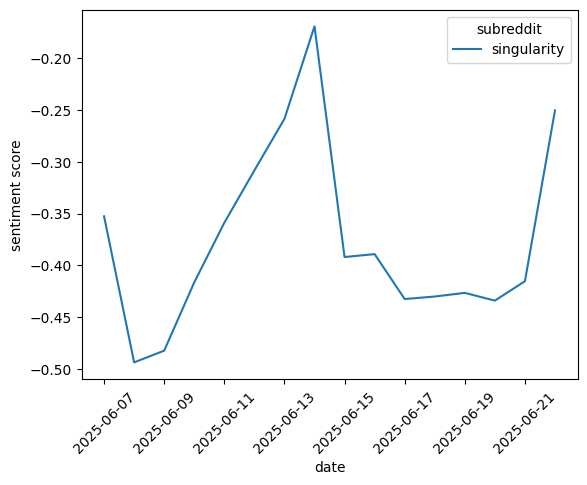

In [188]:
df_history[fil].pipe(pd.pivot_table,index='date',values='community_weighted_sentiment',columns=['subreddit'],aggfunc='max').plot(rot=45,ylabel='sentiment score')

### Method 2: Calculate z-score based on the mean and std of entire May's data

In [189]:
global_stats = (df_summary[pd.to_datetime(df_summary.index).month == 5]
                .groupby('subreddit').agg(mean_cws=('community_weighted_sentiment','mean'),
                                          std_cws=('community_weighted_sentiment','std')
                                          )
               )
global_stats

,mean_cws,std_cws
subreddit,,
LocalLLaMA,-0.485437,0.069627
OpenAI,-0.493694,0.071395
artificial,-0.473540,0.138909
singularity,-0.429887,0.081146


In [196]:
df_summary[['mean_cws','std_cws']] = global_stats.loc[df_summary.subreddit,['mean_cws','std_cws']].values
df_history = df_summary.copy().reset_index()
df_history['z_score'] = (df_history.community_weighted_sentiment - df_history.mean_cws) / df_history.std_cws

In [197]:
df_zscores = df_history.pipe(pd.pivot_table, index='date',columns='subreddit',values='z_score',aggfunc="max")

def highlight_abs_gt_3(val):
    return 'background-color: red' if abs(val) > 3 else ''

styled = df_zscores.style.map(highlight_abs_gt_3)

styled

subreddit,LocalLLaMA,OpenAI,artificial,singularity
date,,,,
2025-05-01,0.108533,-0.326294,-0.237290,-0.071433
2025-05-02,0.728985,0.081725,-0.220718,0.182259
2025-05-03,-0.584901,0.547064,0.779239,0.443977
2025-05-04,2.589418,0.675299,-0.491293,-2.161081
2025-05-05,0.505834,0.947750,0.752050,1.201308
2025-05-06,-0.679105,-0.867288,0.108398,0.487051
2025-05-07,0.080169,0.488811,-0.327867,0.892507
2025-05-08,0.344177,0.144971,-0.400844,-1.018908
2025-05-09,0.866881,1.014110,-0.551819,-1.387403


With the more stable mean and std calculation, seems like we've found an actual spike

In [200]:
date = "2025-05-29"
subreddit = "artificial"

rightwindow = datetime.datetime.strptime(date,"%Y-%m-%d").date()
leftwindow = rightwindow - datetime.timedelta(days=15)


fil = lambda x: x.date.between(leftwindow,rightwindow) & (x.subreddit == subreddit)

df_history[fil]

,date,subreddit,community_weighted_sentiment,mean_cws,std_cws,z_score
54,2025-05-14,artificial,-0.536738,-0.47354,0.138909,-0.454956
58,2025-05-15,artificial,-0.627437,-0.47354,0.138909,-1.107901
62,2025-05-16,artificial,-0.578293,-0.47354,0.138909,-0.754111
66,2025-05-17,artificial,-0.508196,-0.47354,0.138909,-0.249486
70,2025-05-18,artificial,-0.498451,-0.47354,0.138909,-0.179333
74,2025-05-19,artificial,-0.552404,-0.47354,0.138909,-0.567740
78,2025-05-20,artificial,-0.425843,-0.47354,0.138909,0.343371
82,2025-05-21,artificial,-0.628255,-0.47354,0.138909,-1.113788
86,2025-05-22,artificial,-0.690261,-0.47354,0.138909,-1.560167
90,2025-05-23,artificial,-0.323495,-0.47354,0.138909,1.080172


<Axes: xlabel='date', ylabel='sentiment score'>

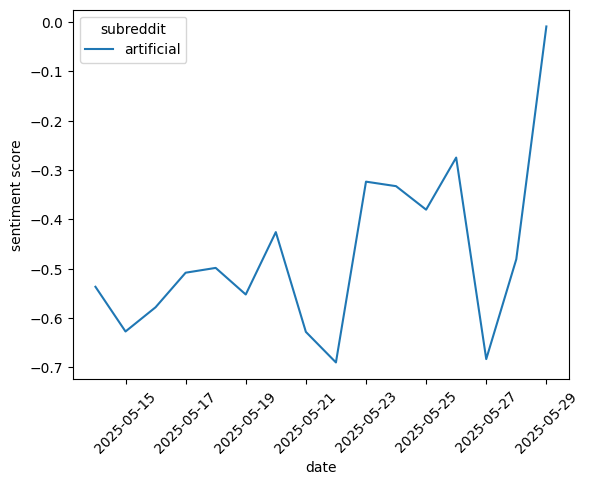

In [201]:
df_history[fil].pipe(pd.pivot_table,index='date',values='community_weighted_sentiment',columns=['subreddit'],aggfunc='max').plot(rot=45,ylabel='sentiment score')